In [32]:
from Aggregator.SimulatedAggregator import SimulatedAggregator
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from random import *
import scipy as sc
import seaborn

from collections import defaultdict

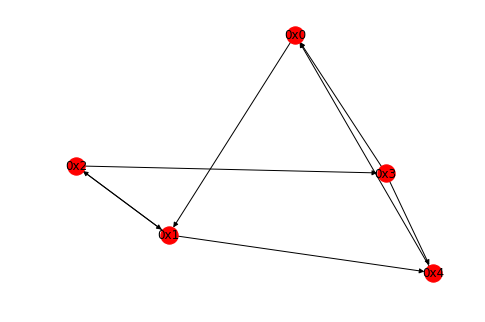

In [33]:
agg = SimulatedAggregator(10, None, 5, 
                          transaction_cost=1, balance_diff_multiplier=20)
nx.draw(agg.networks[0], with_labels=True)
plt.show()

In [34]:
matrix = agg.matrices[0]
goal = agg.goal_balance[0]
abs_max = np.absolute(goal).max()

In [35]:
def base_individual(base_matrix):
    matrix = base_matrix.copy()
    return create_individual(matrix)
    

def create_individual(matrix):
    individual = { "matrix": matrix.tolil() }
    update_individual(individual)
    
    return individual

def update_individual(individual):
    cons_violation, cost = agg.block_cost(individual["matrix"], goal)
    
    individual["cons_violation"] = cons_violation
    individual["cost"] = cost
    individual["combined_cost"] = cost + cons_violation
    individual["valid"] = cons_violation == 0
    individual["crowding_dist"] = 0.
    
correction_matrix = np.ones((5,5)) # change size
np.fill_diagonal(correction_matrix, 0.)

def corrections(matrix):
    matrix = matrix.multiply(correction_matrix).tolil()
    
    matrix[matrix < 0] = 0
    matrix[matrix > abs_max] = abs_max
    
    return matrix.astype(int)


In [36]:
def random_start(shape):        
    m = sc.sparse.rand(*shape, random())
    m *= abs_max
    m = corrections(m)
    
    return m

def mutate(matrix, mutation_rate=0.1, deviations_divider=3):
#     selection = sc.sparse.rand(*matrix.shape, mutation_rate) > 0 # look if always 10% then problem
#     amounts = np.random.normal(0, abs_max/deviations_divider, len(selection.data)).astype(int)

    selection = np.random.random(matrix.shape) < mutation_rate
    amounts   = np.random.normal(0, abs_max/deviations_divider, len(selection[selection==True])).astype(int)        
    
    matrix[selection] += amounts
        
    return matrix

In [37]:
def fast_non_dominant_sort(P, cost="combined_cost"):
    Sx = defaultdict(list) # dict nondominating per p 
    nx = defaultdict(int)  # dict increment dominination counter of p 
    xrank = np.zeros(len(P))
    Fi = []
    
    for pid, pv in enumerate(P):
        for qid, qv in enumerate(P):
            if pv[cost] <= qv[cost]: # if p dominates q -> less cost
                Sx[pid].append(qid)
            else:
                nx[pid] += 1
                
        if nx[pid] == 0:
            xrank[pid] = 1
            Fi.append(pid)
                        
    i = 1
    while Fi:
        Q = []
        
        for p in xrank:
            
            for qid, qv in Sx.items():
                nx[qid] -= 1
                
                if nx[qid] == 0: # q belongs to the next front
                    xrank[qid] = i + 1

                    Q.append(qid)
                    
            i += 1 
            Fi = Q
            
    return xrank          
            

In [38]:
POSITIVE_INFINITY = float("inf")

def crowding_distance(front):
    for i in front:
        i["crowding_dist"] = 0.
    
    n_solutions = len(front)
    
    x, y = front[0]["matrix"].shape
    
    for i in range(x):
        for j in range(y):
            sorted_solutions = sorted(front, key=lambda x: x["matrix"][i, j])      
            sorted_solutions, matrices = zip(*[(x, x["matrix"]) for x in sorted_solutions])

            min_value = matrices[0][i, j]
            max_value = matrices[-1][i, j]
            
            sorted_solutions[0]["crowding_dist"] += POSITIVE_INFINITY
            sorted_solutions[-1]["crowding_dist"] += POSITIVE_INFINITY
            
            for s in range(1, n_solutions-1):
                diff = matrices[s+1][i, j] - matrices[s-1][i, j]
                
                if max_value - min_value == 0:
                    sorted_solutions[s]["crowding_dist"] += 0
                else:
                    sorted_solutions[s]["crowding_dist"] += diff / (max_value - min_value)

In [39]:
def binary_crossover(parent1, parent2, cost="combined_cost"):
    if parent1["matrix"].shape != parent2["matrix"].shape:
        raise Exception("Parents should have same shape")
    
    total = parent1[cost] + parent2[cost]
    P1 = parent1[cost] / total

    selection = np.random.rand(*parent1["matrix"].shape) > P1

    child = parent2["matrix"].copy()
    child[selection] = parent1["matrix"][selection]
    
    return [create_individual(child)]

In [40]:
def SBX_crossover(parent1, parent2, eta=50, cost="nan"):
    if parent1["matrix"].shape != parent2["matrix"].shape:
        raise Exception("Parents should have same shape")
    
    b = np.random.random(parent1["matrix"].shape)
    b[b<0.5] *= 2
    b[b>=0.5] = np.fromiter((1/(2 * (1 - x)) for x in b[b>=0.5]), float)
    b **= (1 / (eta + 1))
    
    child1 = (0.5 * (parent1["matrix"].multiply((b+1)) + parent2["matrix"].multiply((b-1)))).astype(int)
    child2 = (0.5 * (parent1["matrix"].multiply((b-1)) + parent2["matrix"].multiply((b+1)))).astype(int)     
    
    return [create_individual(child1), create_individual(child2)]

In [41]:
def tournament_selector(P, cost="combined_cost", tournament_size=2):
    winner = choice(P)
    
    for _ in range(tournament_size-1):
        candidate = choice(P)
        
        if candidate[cost] > winner[cost]:
            winner = candidate
    
    return winner

In [42]:
def create_children(P, n_children, crossover_method=binary_crossover, cost="combined_cost"):    
    while n_children != 0:
        parents = (tournament_selector(P, cost), tournament_selector(P, cost))
        children = crossover_method(*parents, cost=cost)
        
        for child in children:
            n_children -= 1
            yield child


In [43]:
def NSGAII_step(P, parent_percentage=0.8, cost="combined_cost", correction=False):
    size_pop = len(P)
    n = int(size_pop * parent_percentage)
    
    F = fast_non_dominant_sort(P, cost)
    fronts = sorted(list(set(F)))
    parents = []
    
    i = 0
    f = 1
        
    while len(parents) + len(F[F==f]) < n:
        crowding_distance(P[F==f])
        parents.extend(P[F==f])
        i += 1
        f = fronts[i]
        
    s = sorted(P[F==f], key=lambda x: x["crowding_dist"], reverse=True)
        
    parents.extend(s[:int(n - len(parents))])
       
    children = list(create_children(parents, int(size_pop - n), crossover_method=SBX_crossover, cost=cost))
    
    for child in children:
        child["matrix"] = mutate(child["matrix"])
        
        if correction:
            child["matrix"] = corrections(child["matrix"])
        
        update_individual(child)
    
    return np.array(parents + children)

In [44]:
P = np.array([base_individual(random_start(matrix.shape)) for i in range(100)])
# P = np.array([base_individual(sc.sparse.lil_matrix((5,5))) for i in range(100)])

In [45]:
log_data = []
single_log_data = []

In [59]:
for i in range(1000):
    P = NSGAII_step(P, cost="combined_cost", correction=True)
    
    log_data.append(np.array([(x["cost"], x["cons_violation"], x["combined_cost"]) for x in P]).mean(axis=0))
    
    x = P[0]
    single_log_data.append(np.array([x["cost"], x["cons_violation"], x["combined_cost"]]))    

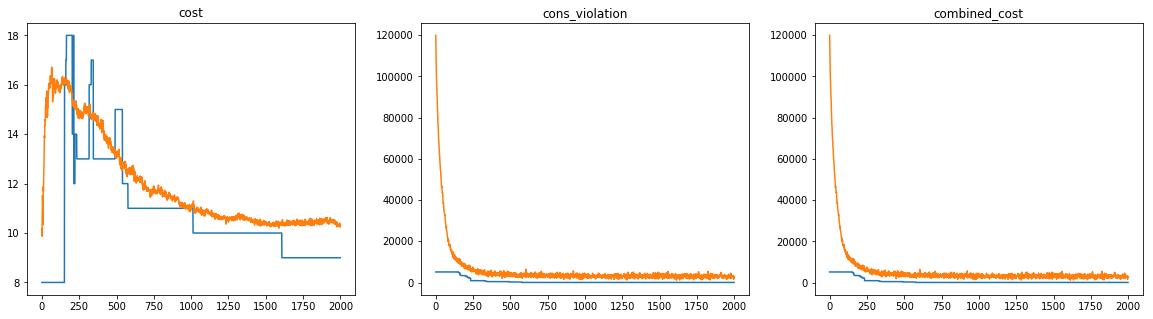

In [60]:
plt.figure(1, figsize=(20, 5))

plt.subplot(131).title.set_text("cost")
plt.plot(np.array(single_log_data)[:,0])
plt.plot(np.array(log_data)[:,0])

plt.subplot(132).title.set_text("cons_violation")
plt.plot(np.array(single_log_data)[:,1])
plt.plot(np.array(log_data)[:,1])

plt.subplot(133).title.set_text("combined_cost")
plt.plot(np.array(single_log_data)[:,2])
plt.plot(np.array(log_data)[:,2])


plt.show()

In [61]:
element = 0
print(P[element])
P[element]["matrix"].toarray()

{'crowding_dist': inf, 'cons_violation': 40, 'valid': False, 'matrix': <5x5 sparse matrix of type '<class 'numpy.int32'>'
	with 10 stored elements in LInked List format>, 'cost': 9, 'combined_cost': 49}


array([[   0,    0, 1376,   43,   20],
       [ 227,    0,    0,    0,    0],
       [   0,    0,    0,   57,   37],
       [   0,    0,   94,    0, 1376],
       [   0,    0,    0,  172,    0]])

In [62]:
matrix.toarray()

array([[   0,  668,    0,    0, 1340],
       [   0,    0,    0,    0, 1512],
       [ 797,    0,    0,  288,    0],
       [   0,  616, 2461,    0,    0],
       [   0,    0,    0, 1591,    0]], dtype=int32)